# Dont' use features that require transform to res variables with celmech in tseries. Almost as good as models that include them

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
Norbits = 1e4
featurefolder = 'spock_featuresNorbits{0:.1f}Nout1000/'.format(Norbits)
trainingdatafolder = datapath+dset+featurefolder

In [3]:
df = pd.read_csv(trainingdatafolder+'trainingdata.csv', index_col=0)
df.head()

,EMfracstdnear,EPstdnear,EMfreestdnear,AMDcritnear,AMDfracnear,AMDstdnear,EMcrossnear,MMRhalfwidthnear,MMRstrengthnear,EMfracstdfar,...,EMfreestdfar,AMDcritfar,AMDfracfar,AMDstdfar,EMcrossfar,MMRhalfwidthfar,MMRstrengthfar,MEGNOmed,MEGNOstd,unstableinshortintegration
0,0.030738,0.000280,0.324549,3.184811e-09,27.378521,0.018187,0.060234,0.005705,0.671084,0.000876,...,NaN,2.034865e-06,0.042851,0.000028,0.504063,NaN,NaN,1.998408,0.063259,0.0
1,0.017365,0.000137,0.282525,1.333975e-08,2.208342,0.016718,0.080547,0.004951,0.335604,0.008915,...,NaN,3.742986e-08,0.787038,0.005958,0.240504,NaN,0.007445,1.996166,0.063637,0.0
2,0.028867,0.001002,0.349528,9.468202e-09,32.212295,0.111564,0.129660,0.010708,1.182296,0.000488,...,0.339598,5.781474e-05,0.005275,0.000018,1.001981,0.011022,0.010598,1.963988,0.109984,0.0
3,0.038106,0.000929,2.010827,2.009257e-06,0.949900,0.002335,0.406112,0.007696,0.710219,0.035091,...,NaN,2.754892e-06,0.692802,0.001703,0.427768,NaN,0.009937,1.979985,0.066412,0.0
4,0.024826,0.002011,0.398929,6.321091e-09,5.962143,0.141701,0.059897,0.003727,0.774914,0.052258,...,0.229094,1.552709e-07,0.242719,0.005769,0.257596,0.006491,0.043042,1.799118,0.187813,0.0


In [4]:
df.shape

(9999, 21)

In [5]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [6]:
Norbits = 1e4

AMD = ['AMDfracnear', 'AMDfracfar', 'AMDstdnear', 'AMDstdfar']
megno = ['MEGNOmed', 'MEGNOstd']
resparamfeatures = ['EMcrossnear', 'EMcrossfar', 'MMRhalfwidthnear', 'MMRstrengthnear']
tseriesshort = ['EPstdnear', 'EPstdfar', 'EMfreestdnear', 'EMfracstdnear', 'EMfracstdfar']

features = AMD + tseriesshort + megno + resparamfeatures 

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [7]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9221851200000002                                  
ERROR                                               
0.004136716578243492                                
SCORE:                                                                        
0.9183137599999999                                                            
ERROR                                                                         
0.0036699508423629025                                                         
SCORE:                                                                        
0.9220100600000001                                                            
ERROR                                                                         
0.0034219507513796607                                                         
SCORE:                                                                        
0.90029786                                                                   

In [8]:
best

{'x_learning_rate': 0.19212918151014208,
 'x_max_depth': 16,
 'x_min_child': 7.0,
 'x_pos_weight': 49.92341396255874,
 'x_subsample': 0.8598087998673086,
 'x_tree_colsample': 0.7147190083308101}

# Would have to set num_boost_round=100 to see the same CV score as in our final fitted model

We're setting n_estimators=100 in model, which is the equivalent of num_boost_round in CV, so if we use the default in CV (10), we will get slightly lower powerformance

In [9]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.917236+0.00277391	test-auc:0.891833+0.00496603
[1]	train-auc:0.945591+0.00591406	test-auc:0.908593+0.00671614
[2]	train-auc:0.958342+0.00435314	test-auc:0.917896+0.00624036
[3]	train-auc:0.964357+0.00630053	test-auc:0.921024+0.00506143
[4]	train-auc:0.969571+0.00391542	test-auc:0.924438+0.00452223
[5]	train-auc:0.974523+0.0024451	test-auc:0.925449+0.00578696
[6]	train-auc:0.977106+0.00173392	test-auc:0.926744+0.00572183
[7]	train-auc:0.980385+0.00104073	test-auc:0.927858+0.00586724
[8]	train-auc:0.983055+0.00074301	test-auc:0.92956+0.00609068
[9]	train-auc:0.985056+0.000657922	test-auc:0.931001+0.00620672


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7147190083308101, gamma=0,
              learning_rate=0.19212918151014208, max_delta_step=0, max_depth=16,
              min_child_weight=7.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=49.92341396255874,
              seed=None, silent=True, subsample=0.8598087998673086)

In [ ]:
dill.dump([model, features, featurefolder], open(datapath+"../models/spock_resonant.pkl", "wb"))

# SPOCK

Text(0.5, 1.0, 'ROC curve (AUC = 0.949)')

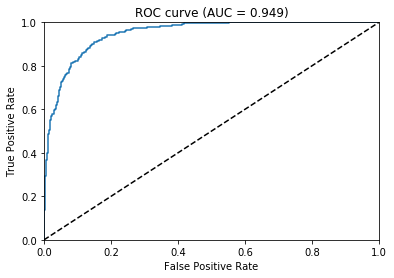

In [10]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [22]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9999746084213257, TPR = 0.0, FPR = 0.0
Threshold 0.9988211989402771, TPR = 0.26062846580406657, FPR = 0.0027416038382453737
Threshold 0.9961404204368591, TPR = 0.37707948243992606, FPR = 0.0075394105551747775
Threshold 0.9896759390830994, TPR = 0.48428835489833644, FPR = 0.013708019191226868
Threshold 0.9818940758705139, TPR = 0.5545286506469501, FPR = 0.019191226867717615
Threshold 0.9691856503486633, TPR = 0.589648798521257, FPR = 0.030843043180260453
Threshold 0.9602527618408203, TPR = 0.6210720887245841, FPR = 0.03769705277587389
Threshold 0.9418101906776428, TPR = 0.6709796672828097, FPR = 0.04386566141192598
Threshold 0.9139188528060913, TPR = 0.7153419593345656, FPR = 0.050034270047978065
Threshold 0.8725294470787048, TPR = 0.7430683918669131, FPR = 0.06031528444139822
Threshold 0.8305062651634216, TPR = 0.7689463955637708, FPR = 0.07196710075394105
Threshold 0.7574278116226196, TPR = 0.8096118299445472, FPR = 0.08156271418779987
Threshold 0.660585343837738, TPR = 0.

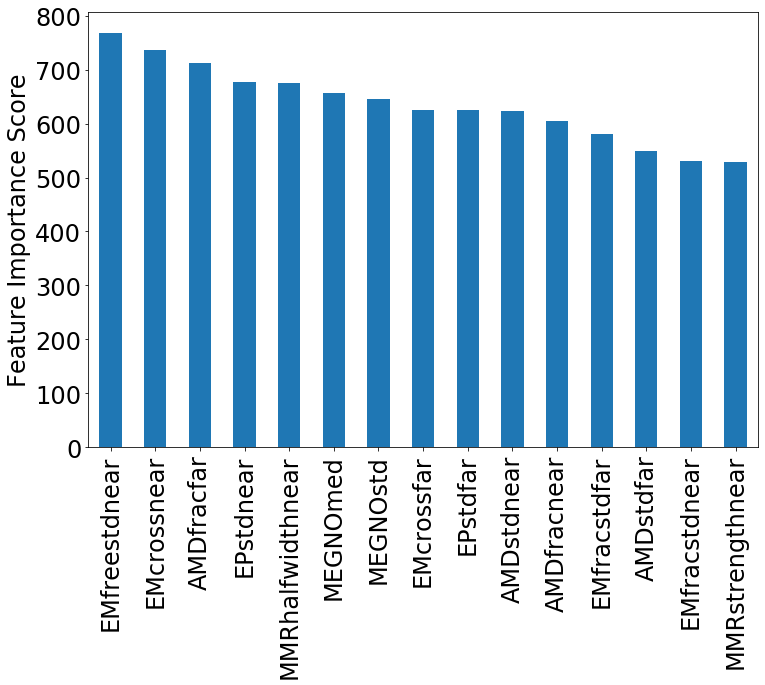

In [20]:
# fe`c`vature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12,8),  fontsize=24)
plt.ylabel('Feature Importance Score', fontsize=24)
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [12]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.0017045966815203428, recall = 1.0, precision = 0.4010378057820608
Threshold 0.0018848502077162266, recall = 0.9981515711645101, precision = 0.4047976011994003
Threshold 0.0020054136402904987, recall = 0.9981515711645101, precision = 0.4094010614101592
Threshold 0.0021861328277736902, recall = 0.9981515711645101, precision = 0.41411042944785276
Threshold 0.002403062302619219, recall = 0.9963031423290203, precision = 0.4181536074476338
Threshold 0.0026803493965417147, recall = 0.9963031423290203, precision = 0.4230769230769231
Threshold 0.0028128228150308132, recall = 0.9963031423290203, precision = 0.42811755361397935
Threshold 0.003113668644800782, recall = 0.9963031423290203, precision = 0.4332797427652733
Threshold 0.003516656346619129, recall = 0.9963031423290203, precision = 0.4385679414157852
Threshold 0.003922741860151291, recall = 0.9963031423290203, precision = 0.4439868204283361
Threshold 0.004709476605057716, recall = 0.9963031423290203, precision = 0.449541284403

In [ ]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

In [ ]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

In [ ]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')